<a href="https://colab.research.google.com/github/xhxuciedu/CS206/blob/master/l1_trend_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem: $\ell_1$ trend filtering

## Introduction

The problem of estimating underlying trends in time series data arises in a variety of disciplines. The $\ell_1$ trend filtering method produces trend estimates $x$ that are piecewise linear from the time series $y\in R^n$.

The $\ell_1$ trend estimation problem can be formulated as
    \begin{array}{ll}
    \mbox{minimize}   &  (1/2)||y-x||_2^2 + \lambda ||Dx||_1,
    \end{array}
with variable $x\in R^n$ , and problem data $y\in R^n$ and $\lambda$, with $\lambda >0$.

$D$ is the $(n-2)\times n$ second difference matrix, 
$$
D = \begin{bmatrix}
    1 & -2 & 1 &  &  & \\
     & 1 & -2 & 1 &  & \\
     & & \ddots & \ddots & \ddots \\
     &  &   & 1 & -2 & 1 
    \end{bmatrix}.
$$


In [0]:
import numpy as np
import pandas as pd
import scipy as scipy
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

## Load data. DON'T CHANGE THIS BLOCK

In [0]:
# download data
# imported the requests library 
import requests 
data_url = "https://drive.google.com/uc?export=download&id=1fAFU6DMI8Xt-nF0YcAq1XPc0Hs3p88Gf"
r = requests.get(data_url) # create HTTP response object 
  
# send a HTTP request to the server and save the HTTP response in a response object called r 
with open("snp500.csv",'wb') as f: 
    # Saving received content as a file 
    # write the contents of the response (r.content) 
    # to a new file in binary mode. 
    f.write(r.content) 

In [0]:
SPY = pd.read_csv('snp500.csv', header=None, names=['date','price'], parse_dates=['date'])
SPY = SPY.set_index('date')

In [0]:
data = SPY['price']['2017':]

In [0]:
# Load time series data: S&P 500 price log.
#y = np.loadtxt(open('data/snp500.txt', 'rb'), delimiter=",", skiprows=1)
y = data.values
n = y.size

# Form second difference matrix.
e = np.ones((1, n))
D = sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)

# Set regularization parameter.
vlambda = 50

##  Use cvxpy to solve the problem - No need to change. For reference only

In [0]:
import cvxpy as cp
import cvxopt as cvxopt

In [184]:
# Solve l1 trend filtering problem.
x = cp.Variable(shape=n)
obj = cp.Minimize(0.5 * cp.sum_squares(y - x)
                  + vlambda * cp.norm(D*x, 1) )
prob = cp.Problem(obj)

# ECOS and SCS solvers fail to converge before
# the iteration limit. Use CVXOPT instead.
prob.solve(solver=cp.CVXOPT, verbose=True)
print('Solver status: {}'.format(prob.status))

# Check for error.
if prob.status != cp.OPTIMAL:
    raise Exception("Solver did not converge!")

print("optimal objective value: {}".format(obj.value))

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+00  2e+06  1e-01  4e-02  1e+00
 1:  2.2669e+02  2.4614e+02  2e+06  1e-01  4e-02  2e+01
 2: -1.4429e+02  3.9345e+00  2e+06  1e-01  4e-02  2e+02
 3: -6.8835e+01  7.0022e+01  1e+06  7e-02  2e-02  1e+02
 4:  4.1348e+02  5.7010e+02  1e+06  7e-02  2e-02  2e+02
 5: -1.2612e+02  1.1485e+02  6e+05  4e-02  1e-02  2e+02
 6:  7.6088e+01  2.5384e+02  4e+05  3e-02  7e-03  2e+02
 7:  9.3038e+02  1.1129e+03  4e+05  3e-02  7e-03  2e+02
 8:  8.0347e+02  8.9064e+02  2e+05  1e-02  3e-03  9e+01
 9:  1.8726e+03  1.9144e+03  7e+04  5e-03  1e-03  4e+01
10:  2.2036e+03  2.2272e+03  4e+04  3e-03  7e-04  2e+01
11:  2.7131e+03  2.7371e+03  4e+04  3e-03  7e-04  2e+01
12:  2.7184e+03  2.7314e+03  2e+04  1e-03  4e-04  1e+01
13:  3.3731e+03  3.3775e+03  7e+03  5e-04  1e-04  4e+00
14:  3.7551e+03  3.7564e+03  2e+03  1e-04  4e-05  1e+00
15:  3.8911e+03  3.8915e+03  8e+02  5e-05  1e-05  5e-01
16:  3.9436e+03  3.9439e+03  4e+02  3e-05  8e-06  

## Plot the solution found by cvxpy

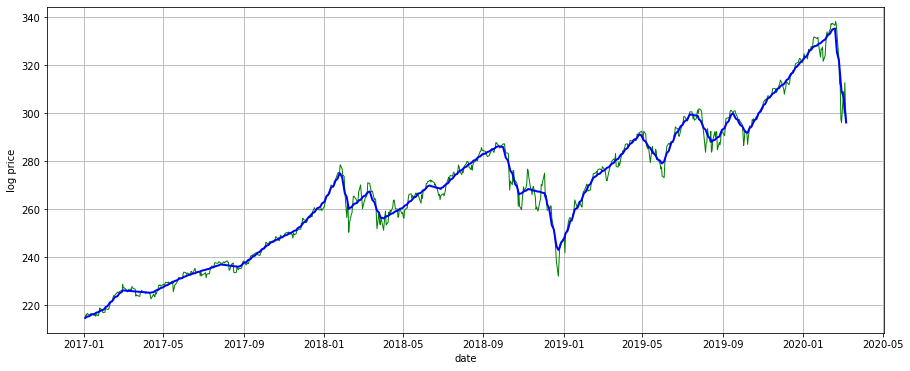

In [185]:
# Plot estimated trend with original signal.
fig,ax = plt.subplots(figsize=(15, 6))
ax.plot(data.index, y, 'g-', linewidth=1.0)
ax.plot(data.index, np.array(x.value), 'b-', linewidth=2.0)
ax.set_xlabel('date')
ax.set_ylabel('log price')
ax.grid()

## Implementing an ADMM (Alternative Direction Method of Multipliers) method


In [0]:
# define the primal objective function
def objective_primal(x,y,vlambda,D):
    return np.linalg.norm(x-y)**2/2 + vlambda*np.linalg.norm(D*x,1)

In [210]:
# TEST THE PRIMAL OBJECTIVE FUNCTION - DON'T CHANGE
# Your output should be 88738.712
print('test primal objective: {:.3f}'.format(objective_primal(y,y, vlambda, D)))  # if we set x=y

test primal objective: 88738.712


In [0]:
# define the dual objective function
def objective_dual(nu, y, vlambda, D):
    eps = 1e-5
    if ((nu<=vlambda+eps) & (nu>=-vlambda-eps)).all():
      tmp= D.T.dot(nu)
      return -np.linalg.norm(tmp)**2/2 + y.dot(tmp)
    else:
      return float('-inf')

In [209]:
# TEST THE DUAL OBJECTIVE FUNCTION - DON'T CHANGE
np.random.seed(1)
nu = np.random.randn(n-2)
# Your output should be -2462.458
print('test dual objective: {:.3f}'.format(objective_dual(nu, y, vlambda, D)))

test dual objective: -2462.458


In [0]:
# Implement the soft-threshold function
def soft_threshold(v, a):
  # v is a vector; a is a sclar
  return np.maximum(v-a,0) - np.maximum(-v-a,0)

In [218]:
# TEST THE SOFT THRESHOLD FUNCTION
v = np.array([-10, 0.5, 10])
a = 2.5
# Your output should be [-7.5, 0., 7.5]
print(soft_threshold(v,a))

[-7.5  0.   7.5]


In [0]:
def ADMM(y, D, vlambda, rho=1.0, init_value=None):
  # initialize
  if init_value is None:
    x = y.copy()
    z = D.dot(x)
    nu = np.zeros(D.shape[0])
  else:
    x, z, nu = init_value
  
  A = rho*D.T.dot(D)+sparse.identity(D.shape[1])

  obj_pri = objective_primal(x, y, vlambda, D)
  obj_dua = objective_dual(nu, y, vlambda, D)
  # iteration
  i = 0
  while obj_pri-obj_dua > 0.1 and i < 5000:
    i += 1

    x = spsolve(A, y+rho*D.T*(z-nu/rho))
    z = soft_threshold(D*x+nu/rho, vlambda/rho)
    nu = nu + rho*(D*x-z)

    obj_pri = objective_primal(x, y, vlambda, D)
    obj_dua = objective_dual(nu, y, vlambda, D)

    print('Iter: {:d} |Dx-z|={:.2f} Primal: {:.3f} Dual: {:.3f} Gap: {:.3f}'.format(i, np.linalg.norm(D*x-z), obj_pri, obj_dua, obj_pri-obj_dua))

  return x, z, nu

In [0]:
tmp = ADMM(y, D, vlambda, 20)